In [1]:
# 1. Gerekli Kütüphanelerin İçe Aktarılması
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFilter
from sklearn.model_selection import train_test_split
import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns

# Görsellerin düzgün görüntülenmesi için matplotlib ayarları
%matplotlib inline

In [2]:
# 2. Sentetik Veri Seti Oluşturma ve CSV Dosyasının Hazırlanması
# 2.1. Veri Seti Klasörlerinin ve Sınıfların Tanımlanması
temel_dizin = 'kromozom_veri_csv'
siniflar = ['XX', 'XY', 'X0']  # Sınıflar
gorsel_boyut = (224, 224)
sinif_basina_gorsel = 300  # Her sınıf için oluşturulacak görüntü sayısı

# Eğer ana klasör yoksa oluştur ve sınıf klasörlerini ekle
if not os.path.exists(temel_dizin):
    os.makedirs(temel_dizin)
    for sinif in siniflar:
        os.makedirs(os.path.join(temel_dizin, sinif))

In [3]:
# 2.2. Sentetik Görsellerin Oluşturulması
def sentetik_gorsel_olustur(sinif_etiketi, gorsel_boyut=(224, 224)):
    gorsel = Image.new('RGB', gorsel_boyut, color='white')
    cizim = ImageDraw.Draw(gorsel)
    
    # Rastgele daire konumları ve boyutları
    def rastgele_daire():
        yaricap = np.random.randint(20, 40)
        x = np.random.randint(yaricap, gorsel_boyut[0] - yaricap)
        y = np.random.randint(yaricap, gorsel_boyut[1] - yaricap)
        return (x - yaricap, y - yaricap, x + yaricap, y + yaricap)
    
    # Sınıflara göre şekillerin tanımlanması
    if sinif_etiketi == 'XX':
        # İki mavi daire
        for _ in range(2):
            cizim.ellipse(rastgele_daire(), fill='blue', outline='blue')
    elif sinif_etiketi == 'XY':
        # Bir mavi ve bir kırmızı daire
        cizim.ellipse(rastgele_daire(), fill='blue', outline='blue')
        cizim.ellipse(rastgele_daire(), fill='red', outline='red')
    elif sinif_etiketi == 'X0':
        # Sadece bir mavi daire
        cizim.ellipse(rastgele_daire(), fill='blue', outline='blue')
    
    # Hafif bulanıklık ekleyerek çeşitlilik katma
    gorsel = gorsel.filter(ImageFilter.GaussianBlur(radius=np.random.uniform(0, 2)))
    
    return gorsel


In [4]:
# 2.3. Görsellerin Oluşturulması ve Kaydedilmesi
gorsel_yollari = []
etiketler = []

for sinif in siniflar:
    sinif_klasoru = os.path.join(temel_dizin, sinif)
    for i in range(sinif_basina_gorsel):
        gorsel = sentetik_gorsel_olustur(sinif, gorsel_boyut)
        gorsel_adi = f'{sinif}_{i}.png'
        gorsel_yolu = os.path.join(sinif_klasoru, gorsel_adi)
        gorsel.save(gorsel_yolu)
        gorsel_yollari.append(gorsel_yolu)
        etiketler.append(sinif)

print("Sentetik veri seti başarıyla oluşturuldu.")


Sentetik veri seti başarıyla oluşturuldu.


In [5]:
# 2.4. CSV Dosyasının Oluşturulması
veri = pd.DataFrame({
    'dosya_yolu': gorsel_yollari,
    'etiket': etiketler
})

csv_dosyasi = os.path.join(temel_dizin, 'kromozom_etiketleri.csv')
veri.to_csv(csv_dosyasi, index=False)

print(f"CSV dosyası başarıyla oluşturuldu: {csv_dosyasi}")


CSV dosyası başarıyla oluşturuldu: kromozom_veri_csv/kromozom_etiketleri.csv


In [6]:
# 3. Veri Setinin Eğitim, Doğrulama ve Test Olarak Bölünmesi
egitim_verisi, gecici_veri = train_test_split(veri, train_size=0.7, stratify=veri['etiket'], random_state=42)
dogrulama_verisi, test_verisi = train_test_split(gecici_veri, train_size=0.5, stratify=gecici_veri['etiket'], random_state=42)

# Bölünmüş veri setlerini ayrı CSV dosyalarına kaydetme
egitim_verisi.to_csv(os.path.join(temel_dizin, 'egitim.csv'), index=False)
dogrulama_verisi.to_csv(os.path.join(temel_dizin, 'dogrulama.csv'), index=False)
test_verisi.to_csv(os.path.join(temel_dizin, 'test.csv'), index=False)

print("Veri seti eğitim, doğrulama ve test olarak başarıyla bölündü.")


Veri seti eğitim, doğrulama ve test olarak başarıyla bölündü.


In [7]:
# 4. CNN Modelinin Tanımlanması
model = Sequential()

# 1. Konvolüsyonel Katman
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# 2. Konvolüsyonel Katman
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 3. Konvolüsyonel Katman
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Düzleştirme
model.add(Flatten())

# Tam Bağlantılı Katman
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Çıkış Katmanı
model.add(Dense(len(siniflar), activation='softmax'))

# Modelin Derlenmesi
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,443 (84.86 MB)

 Trainable params: 22,245,443 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 5. Veri Ön İşleme ve Veri Artırma
# Eğitim verisi için veri artırma ve normalizasyon
egitim_veri_olusturucu = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Dönme açısı
    zoom_range=0.2,  # Yakınlaştırma
    width_shift_range=0.2,  # Yatay kaydırma
    height_shift_range=0.2,  # Dikey kaydırma
    shear_range=0.2,  # Kayma
    horizontal_flip=True,  # Yatay çevirme
    fill_mode="nearest"  # Yakınlaştırma sonrası dolgu
)

# Doğrulama ve test verisi için yalnızca normalizasyon
dogrulama_veri_olusturucu = ImageDataGenerator(rescale=1./255)
test_veri_olusturucu = ImageDataGenerator(rescale=1./255)


In [9]:
# Veri Üreticilerin Tanımlanması
egitim_ureticisi = egitim_veri_olusturucu.flow_from_dataframe(
    egitim_verisi,
    x_col='dosya_yolu',
    y_col='etiket',
    target_size=gorsel_boyut,
    batch_size=32,
    class_mode='categorical'
)

dogrulama_ureticisi = dogrulama_veri_olusturucu.flow_from_dataframe(
    dogrulama_verisi,
    x_col='dosya_yolu',
    y_col='etiket',
    target_size=gorsel_boyut,
    batch_size=32,
    class_mode='categorical'
)

test_ureticisi = test_veri_olusturucu.flow_from_dataframe(
    test_verisi,
    x_col='dosya_yolu',
    y_col='etiket',
    target_size=gorsel_boyut,
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Tahminlerin sıraya uygun olması için
)


Found 630 validated image filenames belonging to 3 classes.
Found 135 validated image filenames belonging to 3 classes.
Found 135 validated image filenames belonging to 3 classes.


In [10]:
# 6. Modelin Eğitilmesi
# Erken durdurma ve model kontrolü için geri çağrımlar (callbacks)
erken_durdur = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_kontrol = ModelCheckpoint('en_iyi_model.keras', monitor='val_loss', save_best_only=True)

# Modelin Eğitilmesi
egitim_gecmisi = model.fit(
    egitim_ureticisi,
    steps_per_epoch=egitim_ureticisi.samples // egitim_ureticisi.batch_size,
    validation_data=dogrulama_ureticisi,
    validation_steps=dogrulama_ureticisi.samples // dogrulama_ureticisi.batch_size,
    epochs=50,  # Modelin öğrenmesi için maksimum epoch sayısı
    callbacks=[erken_durdur, model_kontrol]
)


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 428ms/step - accuracy: 0.4227 - loss: 2.4790 - val_accuracy: 0.6719 - val_loss: 0.5114
Epoch 2/50
 1/19 ━━━━━━━━━━━━━━━━━━━━ 6s 364ms/step - accuracy: 0.7188 - loss: 0.5409

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7188 - loss: 0.5409 - val_accuracy: 0.6562 - val_loss: 0.5122
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 408ms/step - accuracy: 0.6652 - loss: 0.5135 - val_accuracy: 0.8047 - val_loss: 0.4364
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8750 - loss: 0.4016 - val_accuracy: 0.7734 - val_loss: 0.4297
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 415ms/step - accuracy: 0.7139 - loss: 0.4607 - val_accuracy: 0.8672 - val_loss: 0.3727
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7727 - loss: 0.4283 - val_accuracy: 0.8594 - val_loss: 0.3778
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 413ms/step - accuracy: 0.7507 - loss: 0.4416 - val_accuracy: 0.8438 - val_loss: 0.3161
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7500 - loss: 0.4553 - val_accuracy: 0.8594 - val_loss: 0.2743
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 428ms/step - accuracy: 0.8350 - loss: 0.4165 - val_accuracy: 0.8828 - val_loss

In [11]:
# Test verisi ile tahminlerin alınması
tahminler = model.predict(test_ureticisi, steps=test_ureticisi.samples // test_ureticisi.batch_size + 1)
tahmin_edilen_siniflar = np.argmax(tahminler, axis=1)

# Sınıf etiketlerini geri dönüştürme
sinif_indekslerini_etiketlere_cevir = {v: k for k, v in egitim_ureticisi.class_indices.items()}
tahmin_edilen_etiketler = [sinif_indekslerini_etiketlere_cevir[i] for i in tahmin_edilen_siniflar]

# Gerçek etiketler
gercek_etiketler = test_verisi['etiket'].values[:len(tahmin_edilen_siniflar)]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step 


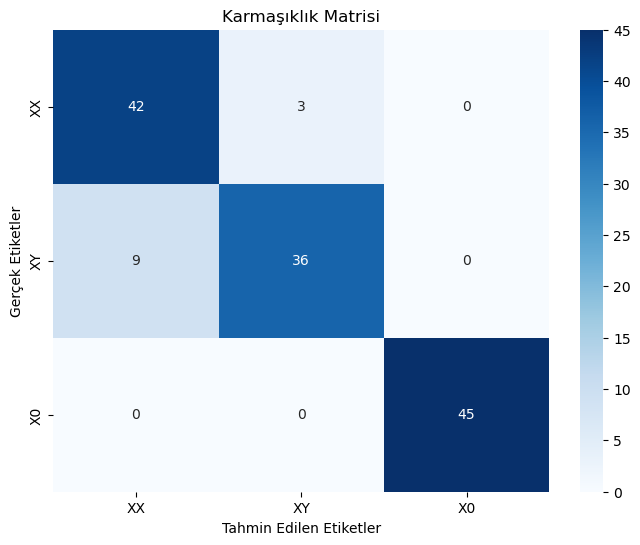

In [12]:
# Karmaşıklık Matrisi
cm = confusion_matrix(gercek_etiketler, tahmin_edilen_etiketler)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=siniflar, yticklabels=siniflar, cmap='Blues')
plt.ylabel('Gerçek Etiketler')
plt.xlabel('Tahmin Edilen Etiketler')
plt.title('Karmaşıklık Matrisi')
plt.show()

In [13]:
# Sınıflandırma Raporu
print("Sınıflandırma Raporu:")
print(classification_report(gercek_etiketler, tahmin_edilen_etiketler, target_names=siniflar))


Sınıflandırma Raporu:
              precision    recall  f1-score   support

          XX       0.82      0.93      0.88        45
          XY       0.92      0.80      0.86        45
          X0       1.00      1.00      1.00        45

    accuracy                           0.91       135
   macro avg       0.92      0.91      0.91       135
weighted avg       0.92      0.91      0.91       135



F1-Skorları:
  Sınıf  F1-Skoru
0    XX  0.857143
1    XY  1.000000
2    X0  0.875000


/var/folders/6v/v5ptn31j0r1fttf53kdt619r0000gn/T/ipykernel_6047/4181524976.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sınıf', y='F1-Skoru', data=f1_df, palette='viridis')


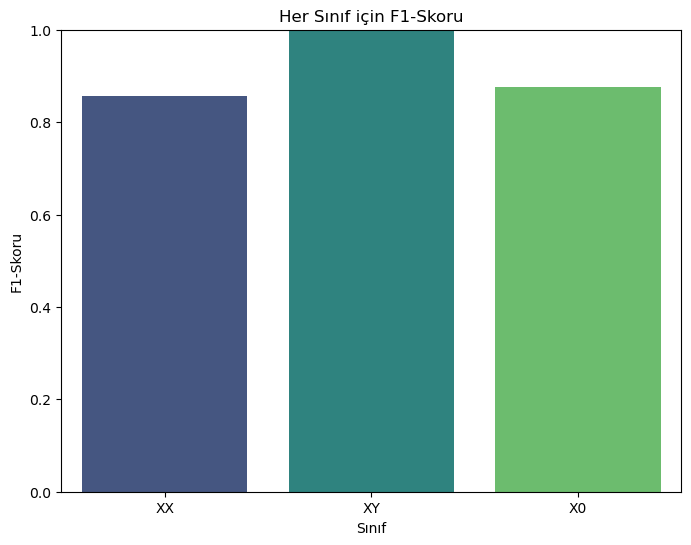

Test Doğruluğu: 91.11%


In [14]:
# F1-Skorunun Hesaplanması
f1_skorlari = f1_score(gercek_etiketler, tahmin_edilen_etiketler, average=None, labels=siniflar)
f1_df = pd.DataFrame({
    'Sınıf': siniflar,
    'F1-Skoru': f1_skorlari
})

print("F1-Skorları:")
print(f1_df)

# F1-Skorlarını Görselleştirme
plt.figure(figsize=(8, 6))
sns.barplot(x='Sınıf', y='F1-Skoru', data=f1_df, palette='viridis')
plt.title('Her Sınıf için F1-Skoru')
plt.ylim(0, 1)
plt.xlabel('Sınıf')
plt.ylabel('F1-Skoru')
plt.show()

# Doğruluk Oranı
dogruluk = accuracy_score(gercek_etiketler, tahmin_edilen_etiketler)
print(f"Test Doğruluğu: {dogruluk * 100:.2f}%")


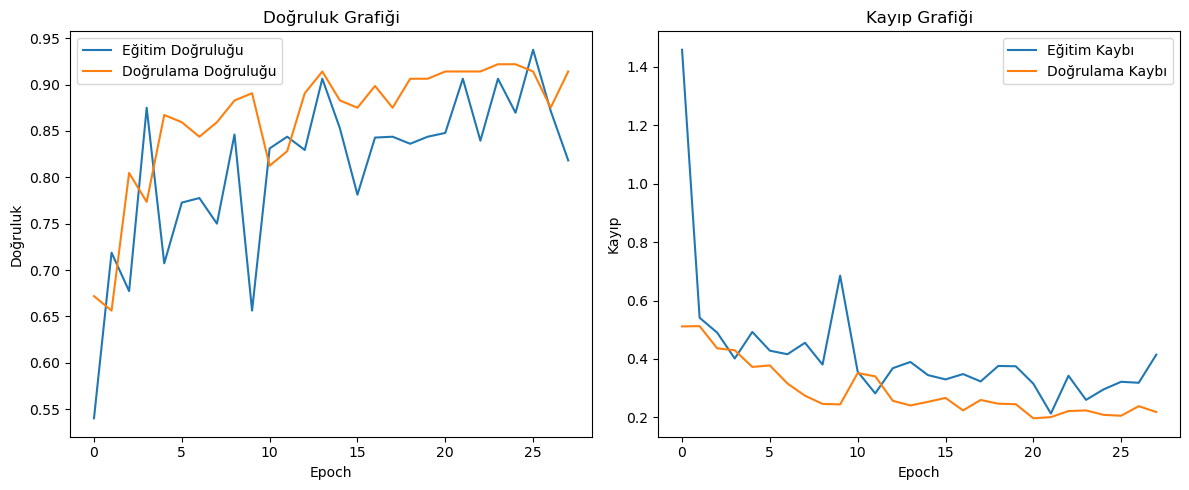

In [15]:
# Eğitim ve Doğrulama Doğruluk ve Kayıp Değerlerinin Grafiği
plt.figure(figsize=(12, 5))

# Doğruluk Grafiği
plt.subplot(1, 2, 1)
plt.plot(egitim_gecmisi.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(egitim_gecmisi.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Kayıp Grafiği
plt.subplot(1, 2, 2)
plt.plot(egitim_gecmisi.history['loss'], label='Eğitim Kaybı')
plt.plot(egitim_gecmisi.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()


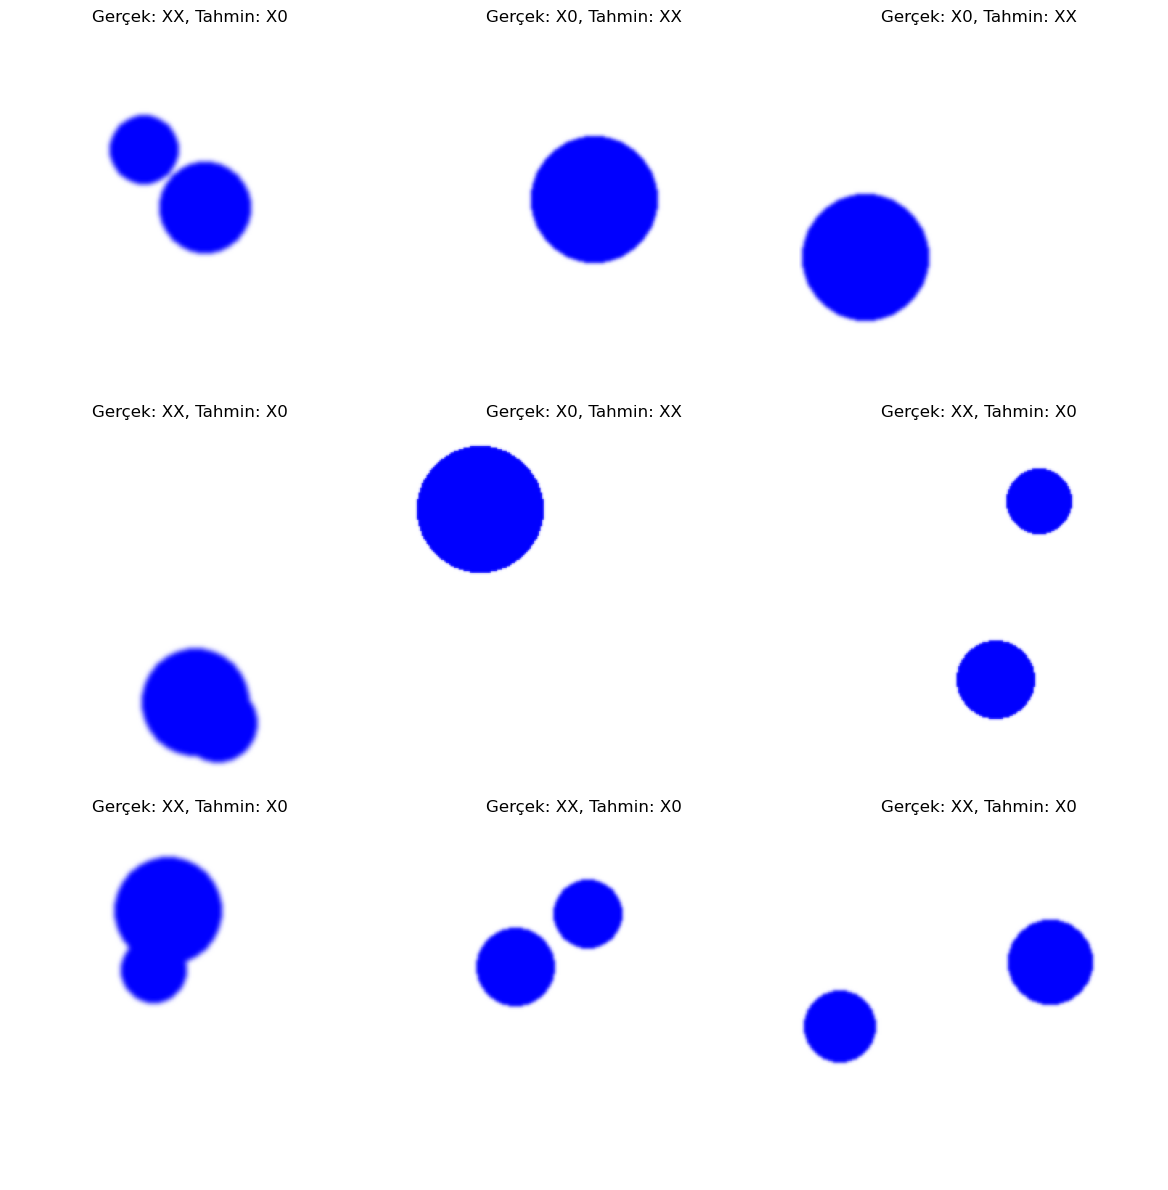

In [16]:
# Yanlış Sınıflandırılan Örneklerin Görselleştirilmesi
yanlis_siniflandirilanlar = np.where(np.array(tahmin_edilen_etiketler) != np.array(gercek_etiketler))[0]

if len(yanlis_siniflandirilanlar) > 0:
    plt.figure(figsize=(12, 12))
    for i, indeks in enumerate(yanlis_siniflandirilanlar[:9]):
        gorsel_yolu = test_verisi.iloc[indeks]['dosya_yolu']
        gorsel = Image.open(gorsel_yolu)
        plt.subplot(3, 3, i + 1)
        plt.imshow(gorsel)
        plt.title(f"Gerçek: {gercek_etiketler[indeks]}, Tahmin: {tahmin_edilen_etiketler[indeks]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Tüm test örnekleri doğru sınıflandırıldı!")
